# Context

Online travel agencies (OTAs) and hotel platforms adjust prices based on factors like lead-time, room type, seasonality, and cancellations. While price changes are common, customer responses to these changes vary. This project explores **price elasticity of demand** for hotel rooms, identifying when higher prices reduce bookings, when they’re tolerated, and how this sensitivity varies across customer segments. By combining elasticity analysis with behavioral and acquisition insights, the project supports a **segmentation strategy to better understand and serve distinct guest profiles**.

Because the raw data file does not contain an explicit *“demand”* field, for simplicity sake, **I define demand** as the ***daily count of non-cancelled bookings***. That derived metric will serve as the dependent variable throughout the analysis.   

> You can find the dataset [here](https://www.kaggle.com/datasets/ahmedwaelnasef/hotel-booking).   
> View full analysis on [Kaggle](...).

_**In this analysis, I will be performing the following:**_

---

### Objectives

- **Most in demand room options**:  
  Identify the hotel’s most popular room types by non-cancelled booking volume.

- **Estimate price elasticity of demand**:  
  Analyse how price changes affect booking volume for these rooms to determine if demand is *elastic or inelastic*.

- **Customer segmentation for Segmentation, Targeting & Positioning ***(STP)*****:  
  Segment customers using key behavioral and acquisition features to inform targeted marketing and positioning strategies.

---

**NOTE**: This project is part of my weekly series in efforts to **demystify applied statistical techniques through real-world, project-driven examples**, making concepts like propensity modelling, causal inference, and evaluation metrics more accessible to practitioners of all backgrounds.


### Let's connect! --> [LinkedIn](https://www.linkedin.com/in/einstein-ebereonwu/) | [X](https://x.com/einsteinmuna) | [GitHub.](https://github.com/munas-git)

# Importing Important Libraries

In [1]:
# data wrangling
import pandas as pd
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

# numerical analysis
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks

# wholistic outlier/anomaly detection
from sklearn.ensemble import IsolationForest

# data vis
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# model training
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsRegressor

# model evaluation
from sklearn.metrics import silhouette_score, mean_squared_error

# hyper-params optimisation
from sklearn.model_selection import GridSearchCV

# handling warnings
import warnings
warnings.filterwarnings('ignore')

print('All done...')

All done...


In [2]:
df = pd.read_csv('/kaggle/input/hotel-booking/Hotel.csv')
df.head()

,ID,n_adults,n_children,weekend_nights,week_nights,meal_plan,car_parking_space,room_type,lead_time,year,month,date,market_segment,repeated_guest,previous_cancellations,previous_bookings_not_canceled,avg_room_price,special_requests,status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


# Initial EDA, Feature Engineering & Table Merging.

## Initial EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              36275 non-null  object 
 1   n_adults                        36275 non-null  int64  
 2   n_children                      36275 non-null  int64  
 3   weekend_nights                  36275 non-null  int64  
 4   week_nights                     36275 non-null  int64  
 5   meal_plan                       36275 non-null  object 
 6   car_parking_space               36275 non-null  int64  
 7   room_type                       36275 non-null  object 
 8   lead_time                       36275 non-null  int64  
 9   year                            36275 non-null  int64  
 10  month                           36275 non-null  int64  
 11  date                            36275 non-null  int64  
 12  market_segment                  

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
n_adults,36275.0,1.844962,0.518715,0.0,2.0,2.00,2.0,4.0
n_children,36275.0,0.105279,0.402648,0.0,0.0,0.00,0.0,10.0
weekend_nights,36275.0,0.810724,0.870644,0.0,0.0,1.00,2.0,7.0
week_nights,36275.0,2.204300,1.410905,0.0,1.0,2.00,3.0,17.0
car_parking_space,36275.0,0.030986,0.173281,0.0,0.0,0.00,0.0,1.0
lead_time,36275.0,85.232557,85.930817,0.0,17.0,57.00,126.0,443.0
year,36275.0,2017.820427,0.383836,2017.0,2018.0,2018.00,2018.0,2018.0
month,36275.0,7.423653,3.069894,1.0,5.0,8.00,10.0,12.0
date,36275.0,15.596995,8.740447,1.0,8.0,16.00,23.0,31.0
repeated_guest,36275.0,0.025637,0.158053,0.0,0.0,0.00,0.0,1.0


**Observation**   

No missing data, that's good.   

However, there are outliers... Some quite extreme like `zero avg_room_price`, `n_children` and `week_nights`, and some others which are not so extreme. There is also no repeated data. For further understanding of the potential outliers, I will be taking a closer look using box plots.   

**Note:**  
I identified potential outliers from the describe table statistics by examining the ***mean, standard deviation, and maximum values***. *With the assumption that the data follows an approximately normal distribution*, I flagged observations as outliers if they fall beyond 3 standard deviations from the mean (99.7th percentile).

## Basic Outlier detection

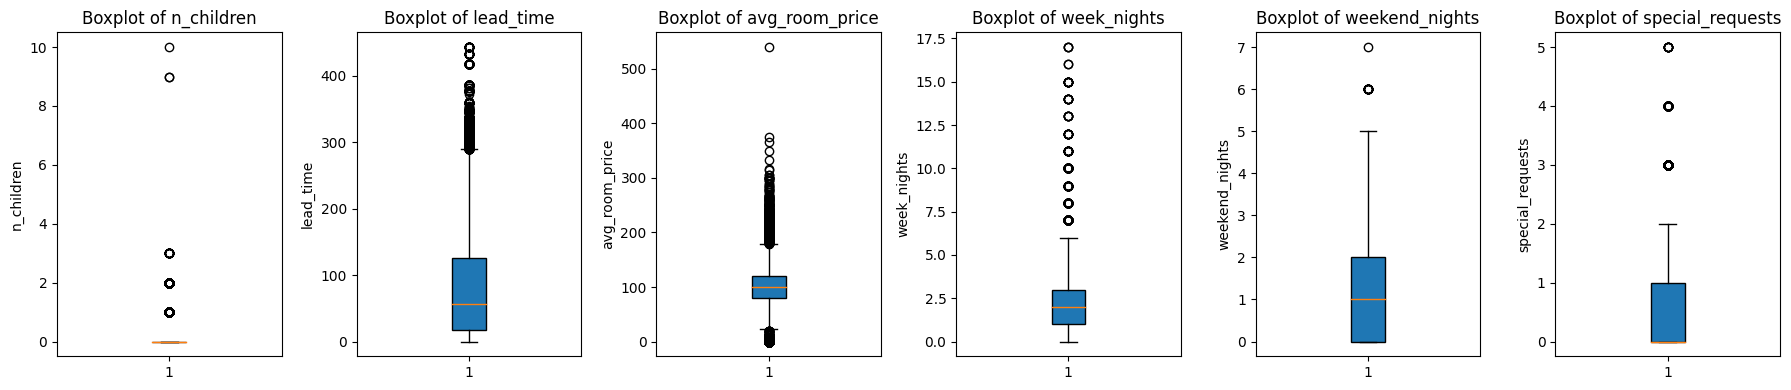

In [5]:
cols_to_plot = [
    'n_children', 'lead_time', 'avg_room_price',
    'week_nights', 'weekend_nights', 'special_requests']

plt.figure(figsize = (18, 4))

for i, col in enumerate(cols_to_plot, start = 1):
    plt.subplot(1, 6, i)
    plt.boxplot(df[col], patch_artist = True)
    plt.title(f'Boxplot of {col}')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

In [6]:
print(f'Different room types: {sorted(df.room_type.unique())}')
df[df['n_children'] > 8].sort_values(by = 'n_children', ascending = False)

Different room types: ['Room_Type 1', 'Room_Type 2', 'Room_Type 3', 'Room_Type 4', 'Room_Type 5', 'Room_Type 6', 'Room_Type 7']


,ID,n_adults,n_children,weekend_nights,week_nights,meal_plan,car_parking_space,room_type,lead_time,year,month,date,market_segment,repeated_guest,previous_cancellations,previous_bookings_not_canceled,avg_room_price,special_requests,status
6338,INN06339,2,10,0,2,Meal Plan 1,0,Room_Type 4,37,2018,1,12,Online,0,0,0,84.45,1,Not_Canceled
10041,INN10042,1,9,2,1,Meal Plan 1,0,Room_Type 1,11,2017,10,11,Corporate,0,0,0,95.00,0,Not_Canceled
10061,INN10062,2,9,2,5,Meal Plan 1,0,Room_Type 2,8,2017,8,13,Online,0,0,0,76.50,1,Canceled


In [7]:
original_avg_room_price_1p8_percentile = df['avg_room_price'].quantile(0.018)
print(f'Unclean dataset "avg_room_price" 1.8th percentile: {original_avg_room_price_1p8_percentile:.2f}')

Unclean dataset "avg_room_price" 1.8th percentile: 36.25


**Observations**

- **`n_children`**: Based on the boxplot, values above **8 children** clearly stand out as potential outliers. However, upon closer inspection, I noticed that:
  - The **highest value** (10 children) occurred in **Room_Type 4**, which I assume is one of the **larger room types**.
  - The booking was made around **New Year**, a time known for **gatherings or events**.
  - The guest also included a **special request**, suggesting this may have been a **group event or party**, rather than a single family booking.

**Note**  
Since the outliers identified here is quite plausible, simply dropping all **univariate outliers** wouldn't be wise, and I don't want to have to individually inspect `lead_time, average_room_price,` and the rest in the same manner, only to observe similar plausible patterns. There are very obvious issues with the `average room prices`, as quite a number of them are 0 or near it. I will handle that shortly.   

For a more robust approach to outlier identification, I'll be working with **Isolation Forests**. This technique helps identify **observation-level outliers** rather than just feature-level anomalies, a more **holistic and scalable** approach, especially useful for **production settings**.

## Initial Feature Engineering + Advanced Outlier Detection & Handling

In [8]:
# ordinal category mappings
meal_plan_mapping = {'Not Selected': -1, 'Meal Plan 1': 1, 'Meal Plan 2': 2, 'Meal Plan 3': 3}
room_type_mapping = {'Room_Type 1': 1, 'Room_Type 2': 2, 'Room_Type 3': 3, 'Room_Type 4': 4, 
                     'Room_Type 5': 5, 'Room_Type 6': 6, 'Room_Type 7': 7}

df['meal_plan'] = df['meal_plan'].map(meal_plan_mapping)
df['room_type'] = df['room_type'].map(room_type_mapping)


# label encoding... binary
status_le = LabelEncoder()
df['status'] = status_le.fit_transform(df['status'])

# one-hot encode nominal category
ohe = OneHotEncoder(sparse_output = False, dtype = int, drop = 'first')
market_segment_encoded = ohe.fit_transform(df[['market_segment']])

feature_names = [f"market_segment_{cat}" for cat in ohe.categories_[0][1:]] # excluding first
for i, col_name in enumerate(feature_names):
    df[col_name] = market_segment_encoded[:, i]

df = df.drop('market_segment', axis = 1)

In [9]:
df.head()

,ID,n_adults,n_children,weekend_nights,week_nights,meal_plan,car_parking_space,room_type,lead_time,year,...,repeated_guest,previous_cancellations,previous_bookings_not_canceled,avg_room_price,special_requests,status,market_segment_Complementary,market_segment_Corporate,market_segment_Offline,market_segment_Online
0,INN00001,2,0,1,2,1,0,1,224,2017,...,0,0,0,65.00,0,1,0,0,1,0
1,INN00002,2,0,2,3,-1,0,1,5,2018,...,0,0,0,106.68,1,1,0,0,0,1
2,INN00003,1,0,2,1,1,0,1,1,2018,...,0,0,0,60.00,0,0,0,0,0,1
3,INN00004,2,0,0,2,1,0,1,211,2018,...,0,0,0,100.00,0,0,0,0,0,1
4,INN00005,2,0,1,1,-1,0,1,48,2018,...,0,0,0,94.50,0,0,0,0,0,1


In [10]:
X = df.drop(['ID'], axis = 1)

iso = IsolationForest(n_estimators = 300, contamination = 0.001, random_state = 42)
iso.fit(X)

df['iso_flag']  = iso.predict(X)
df['iso_score'] = iso.decision_function(X)

outliers = (df[df['iso_flag'] == -1].sort_values('iso_score'))

# display(outliers)

In [11]:
print(f'Outliers percentage: {round(len(df[df["iso_flag"] == -1]) / len(df) * 100, 4)}%')
print(f'Number of identified outliers: {len(df[df["iso_flag"] == -1])}')
print(f'Number of borderline observations (confusing to decice by model): {len(df[df["iso_score"] == 0])}')

Outliers percentage: 0.102%
Number of identified outliers: 37
Number of borderline observations (confusing to decice by model): 0


In [12]:
# Quick sanity check... is the January case of 10 kids and room type 4 flagged?
'INN06339' in outliers['ID'].values

False

### Further dive into what exactly makes them outliers

In [13]:
# In this cell, I use each tree to extract the decision path for each sample,
# then track which features were used to isolate each outlier.
# Features that appear earlier in the path get more weight.
# In the end, I quantify how much each feature contributed to the isolation,
# helping explain which feature combinations result in rare/anomalous observations.


# ====================== VERY IMPORTANT REUSABLE FUNCTION FOR FUTURE PROJECTS (Outlier Flag Explainability) ======================
def get_contributions(model, X, row_idx, feature_names, threshold = 0.05):
    x = X[row_idx].reshape(1, -1)
    contrib = np.zeros(X.shape[1])

    for tree in model.estimators_:
        node_ids = tree.decision_path(x).indices
        for depth, node_id in enumerate(node_ids, start = 1):
            feat = tree.tree_.feature[node_id]
            if feat >= 0:
                contrib[feat] += 1 / depth # higher weight to quicker splits... inverse or smaller numbers are higher
            else:
                break
                
    contrib /= contrib.sum()
    return pd.Series(contrib, index = feature_names, name = row_idx)
# ====================== VERY IMPORTANT REUSABLE FUNCTION FOR FUTURE PROJECTS (Outlier Flag Explainability) ======================



# outliers only
outlier_idx = df[df['iso_flag'] == -1].sort_values('iso_score').index
feature_names = X.columns

contrib_df = pd.DataFrame([
    get_contributions(iso, X.values, i, feature_names)
    for i in outlier_idx], index = outlier_idx)

value_df = X.loc[outlier_idx].copy()
value_df['iso_score'] = df.loc[outlier_idx, 'iso_score']
gmap = contrib_df.where(contrib_df > 0.05, 0.0)
gmap["iso_score"] = 0.0

styled = (value_df.style.background_gradient(cmap = 'Reds', axis = None, gmap = gmap).format('{:.4f}'))


print('NOTE: The heavier the shade of red, the more significant the feature was in determining the observation is an outlier\n')
display(styled) # .... This only works in notebook environments, so I suggest viewing the Kaggle notebook.

NOTE: The heavier the shade of red, the more significant the feature was in determining the observation is an outlier



,n_adults,n_children,weekend_nights,week_nights,meal_plan,car_parking_space,room_type,lead_time,year,month,date,repeated_guest,previous_cancellations,previous_bookings_not_canceled,avg_room_price,special_requests,status,market_segment_Complementary,market_segment_Corporate,market_segment_Offline,market_segment_Online,iso_score
21880,1.0000,0.0000,2.0000,1.0000,1.0000,1.0000,1.0000,11.0000,2018.0000,12.0000,17.0000,1.0000,5.0000,57.0000,67.0000,2.0000,1.0000,0.0000,1.0000,0.0000,0.0000,-0.0385
23366,4.0000,0.0000,0.0000,1.0000,1.0000,1.0000,7.0000,4.0000,2018.0000,5.0000,13.0000,1.0000,0.0000,2.0000,0.0000,4.0000,1.0000,1.0000,0.0000,0.0000,0.0000,-0.0315
8622,1.0000,0.0000,1.0000,0.0000,1.0000,1.0000,1.0000,5.0000,2018.0000,12.0000,5.0000,1.0000,2.0000,8.0000,0.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,-0.0290
33393,1.0000,0.0000,0.0000,3.0000,1.0000,1.0000,4.0000,0.0000,2018.0000,1.0000,5.0000,1.0000,0.0000,12.0000,0.0000,2.0000,1.0000,1.0000,0.0000,0.0000,0.0000,-0.0274
27665,2.0000,0.0000,1.0000,1.0000,1.0000,0.0000,7.0000,0.0000,2018.0000,12.0000,19.0000,1.0000,4.0000,20.0000,0.0000,2.0000,1.0000,1.0000,0.0000,0.0000,0.0000,-0.0270
3050,1.0000,0.0000,0.0000,1.0000,1.0000,0.0000,7.0000,0.0000,2018.0000,5.0000,4.0000,1.0000,4.0000,15.0000,0.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,-0.0246
18794,1.0000,0.0000,0.0000,2.0000,1.0000,1.0000,1.0000,7.0000,2018.0000,12.0000,14.0000,1.0000,5.0000,56.0000,67.0000,2.0000,1.0000,0.0000,1.0000,0.0000,0.0000,-0.0246
36080,1.0000,0.0000,1.0000,1.0000,1.0000,0.0000,7.0000,0.0000,2018.0000,3.0000,21.0000,1.0000,3.0000,15.0000,0.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,-0.0228
19292,3.0000,0.0000,0.0000,1.0000,1.0000,0.0000,7.0000,71.0000,2018.0000,10.0000,15.0000,1.0000,0.0000,32.0000,0.0000,4.0000,1.0000,1.0000,0.0000,0.0000,0.0000,-0.0224
35983,1.0000,0.0000,0.0000,1.0000,1.0000,0.0000,7.0000,0.0000,2018.0000,6.0000,7.0000,1.0000,4.0000,17.0000,0.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,-0.0217


**Observation**

This technique was not only effective in identifying records with an `avg_room_price` of **0.0**, but it also identified other **rare booking combinations**. For example, bookings made for **1 adult to span across 2 weekend nights and 1 week night, with 2 special requests in December** is quite uncommon for this hotel.... Something more common based on my own intuition would be 2 adults and at least 1 child, for that time of the year. Anyways, `I will be proceeding with a 2-step approach`....   

**1.** ***Dropping Outliers***   
I will be dropping every single identified outlier, since there are only 37 of them and not a significant loss compared to the amount of data I have. Next, I will also be excluding every observation with room price above 400, in order to avoid unnecessary skewing.

**2.** ***Imputing Wrong Prices***

After removing the outliers, I will be **replacing the `avg_room_price` values of 0** with predictions from a **K-Nearest Neighbors (KNN) regressor**, using booking-specific patterns across all features in order to balance **precision** with **robustness** unlike a mean fill which may have lost some finer details.

In [14]:
df_clean = df.drop(outliers.index)
print(f'Number of cleaned observations with room price above 400 --> {len(df_clean[df_clean["avg_room_price"] >= 400])}')

df_clean = df_clean[df_clean['avg_room_price'] < 400]

Number of cleaned observations with room price above 400 --> 1


In [15]:
# some clean up

cleanup_cols = ['ID', 'iso_flag', 'iso_score']
df_clean.drop(cleanup_cols, axis = 1, inplace = True)

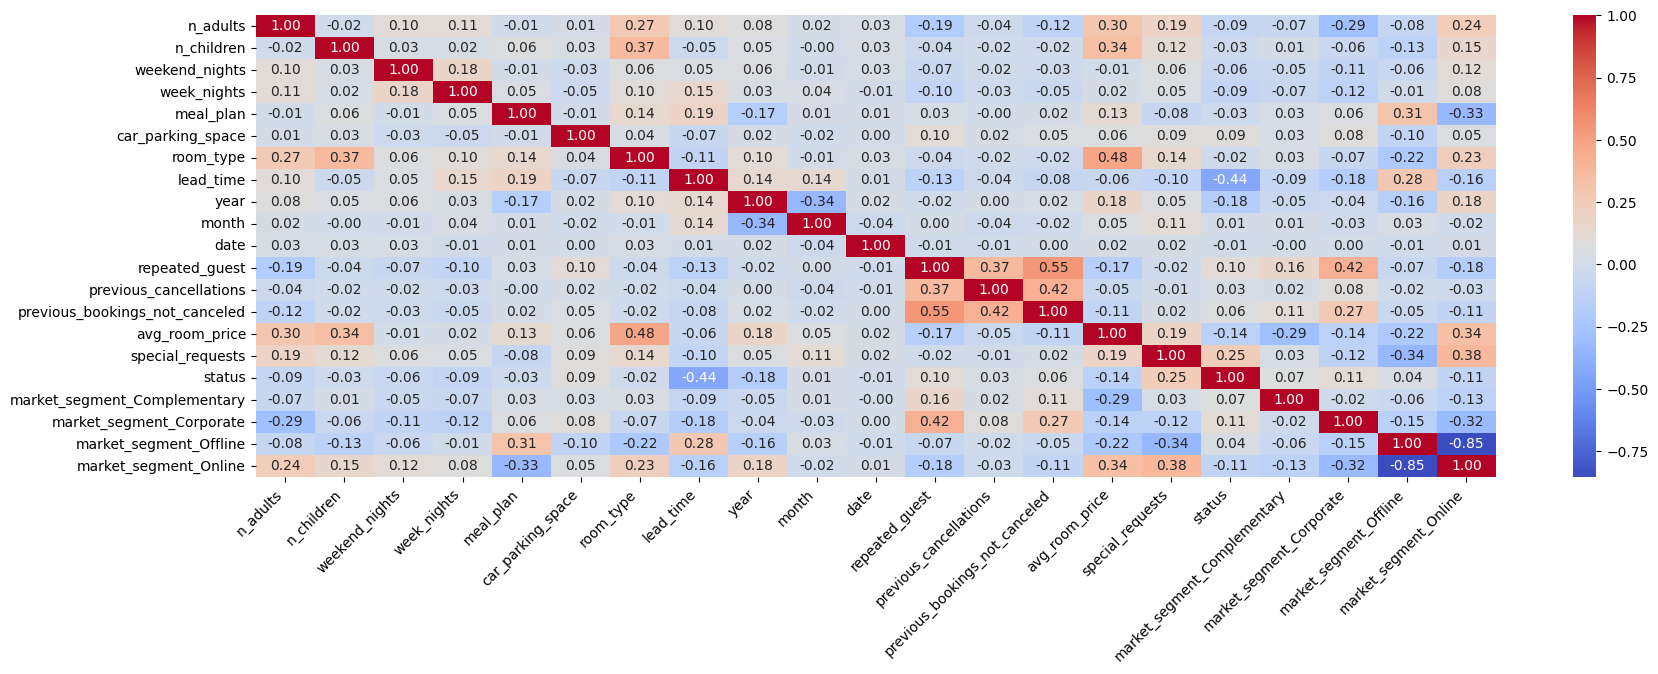

In [16]:
corr = df_clean.corr()

plt.figure(figsize = (20, 6))
sns.heatmap(corr, annot = True, fmt = '.2f', cmap = 'coolwarm')
plt.xticks(rotation = 45, ha = 'right');

**Observation**

As expected, the one-hot-encoded variables are highly correlated, and will be ignored. Asides those, the `repeated_guest` and `previous_bookings_not_canceled` are highly correlated with a correlation score of ***0.55***. I will be dropping `repeated_guest` because any `previous_bookings_not_canceled` *> 1* automatically equates to a repeat guest and the number of prevoous bookings not cancelled carries more information than just a boolean flag.

In [17]:
# some extra clean up

cleanup_cols = ['repeated_guest']
df_clean.drop(cleanup_cols, axis = 1, inplace = True)

print(f'Number of cleaned observations with unlikely average price: {len(df_clean[df_clean["avg_room_price"] <= original_avg_room_price_1p8_percentile])}')

Number of cleaned observations with unlikely average price: 629


## KNN Data Imputation

In [18]:
df_clean.head()

,n_adults,n_children,weekend_nights,week_nights,meal_plan,car_parking_space,room_type,lead_time,year,month,date,previous_cancellations,previous_bookings_not_canceled,avg_room_price,special_requests,status,market_segment_Complementary,market_segment_Corporate,market_segment_Offline,market_segment_Online
0,2,0,1,2,1,0,1,224,2017,10,2,0,0,65.00,0,1,0,0,1,0
1,2,0,2,3,-1,0,1,5,2018,11,6,0,0,106.68,1,1,0,0,0,1
2,1,0,2,1,1,0,1,1,2018,2,28,0,0,60.00,0,0,0,0,0,1
3,2,0,0,2,1,0,1,211,2018,5,20,0,0,100.00,0,0,0,0,0,1
4,2,0,1,1,-1,0,1,48,2018,4,11,0,0,94.50,0,0,0,0,0,1


In [19]:
train_df = df_clean[df_clean['avg_room_price'] > original_avg_room_price_1p8_percentile].copy()
pred_df  = df_clean[df_clean['avg_room_price'] <= original_avg_room_price_1p8_percentile].copy()

feature_cols = [c for c in df_clean.columns if c != 'avg_room_price']
X_train = train_df[feature_cols]
y_train = train_df['avg_room_price']
X_pred  = pred_df[feature_cols]

cat_cols = [c for c in feature_cols if c.startswith('market_segment_') or c in ['meal_plan', 'room_type', 'status']]
ordinal_cols = [c for c in feature_cols if c not in cat_cols]

# ordinal feature scaling
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_pred_scaled = X_pred.copy()

X_train_scaled[ordinal_cols] = scaler.fit_transform(X_train[ordinal_cols])
X_pred_scaled[ordinal_cols] = scaler.transform(X_pred[ordinal_cols])

# Grid search for best k
param_grid = {'n_neighbors': [3, 5, 6, 7, 9, 11]}
cv = KFold(n_splits = 5, shuffle = True, random_state = 42)

gs = GridSearchCV(KNeighborsRegressor(metric = 'euclidean'),
                  param_grid, cv = cv,
                  scoring = 'neg_mean_squared_error', n_jobs = -1)
gs.fit(X_train_scaled, y_train)

print(f'Best k: {gs.best_params_["n_neighbors"]}  (CV RMSE ~= {(-gs.best_score_) ** 0.5:0.1f})')

# filling outlier prices.
best_knn = gs.best_estimator_
pred_prices = best_knn.predict(X_pred_scaled)
df_clean.loc[df_clean['avg_room_price'] <= original_avg_room_price_1p8_percentile, 'avg_room_price'] = pred_prices

df_clean['avg_room_price'].describe()

Best k: 6  (CV RMSE ~= 18.1)


count    36237.000000
mean       105.249803
std         32.450663
min         36.380000
25%         81.000000
50%        100.000000
75%        121.000000
max        375.500000
Name: avg_room_price, dtype: float64

**Observation**

Price descriptive stats look wayyy better than before... Time for further analysis, engineering demand feature, and moving on to price elasticity of demand modelling, then studying the different demand segments identified.

# Advanced EDA

In [20]:
invalid_dates_info = []

for idx, row in df_clean.iterrows():
    try:
        year, month, day = int(row['year']), int(row['month']), int(row['date'])
        pd.to_datetime(f"{year}-{month:02d}-{day:02d}")
    except Exception as e:
        invalid_dates_info.append({
            'index': idx,
            'year': year,
            'month': month, 
            'day': day,
            'date_string': f"{year}-{month:02d}-{day:02d}",
            'error': str(e)})

print(f"Found {len(invalid_dates_info)} invalid dates:")
print("-" * 60)

for item in invalid_dates_info[:5]:
    print(f"Index {item['index']}: {item['date_string']} - {item['error']}")

Found 37 invalid dates:
------------------------------------------------------------
Index 2626: 2018-02-29 - day is out of range for month: 2018-02-29, at position 0
Index 3677: 2018-02-29 - day is out of range for month: 2018-02-29, at position 0
Index 5600: 2018-02-29 - day is out of range for month: 2018-02-29, at position 0
Index 6343: 2018-02-29 - day is out of range for month: 2018-02-29, at position 0
Index 7648: 2018-02-29 - day is out of range for month: 2018-02-29, at position 0


In [21]:
df_clean['booking_date'] = pd.to_datetime(
    df_clean['year'].astype(str) + '-' + 
    df_clean['month'].astype(str) + '-' + 
    df_clean['date'].astype(str),
    errors = 'coerce')

print(f'Number of bookings on "2018-02-28": {len(df_clean[df_clean["booking_date"] == "2018-02-28"])}')
print(f'Number of bookings on "2018-03-01": {len(df_clean[df_clean["booking_date"] == "2018-03-01"])}\n')
print(f'\nSuccessful/Valid date conversions: {df_clean["booking_date"].notna().sum()}')

Number of bookings on "2018-02-28": 165
Number of bookings on "2018-03-01": 59


Successful/Valid date conversions: 36200


**Observation**

Turns out some records were **wrongly recorded as 29th of February 2018**, even though that year was **not a leap year**... 

Honestly, I **don't want to be too smart** and move the data to either day before/after since I **don't have records for other significant years to observe**, so I will be **excluding all that phantom data entirely** 

**Oh well...**

## Overall Daily Demand

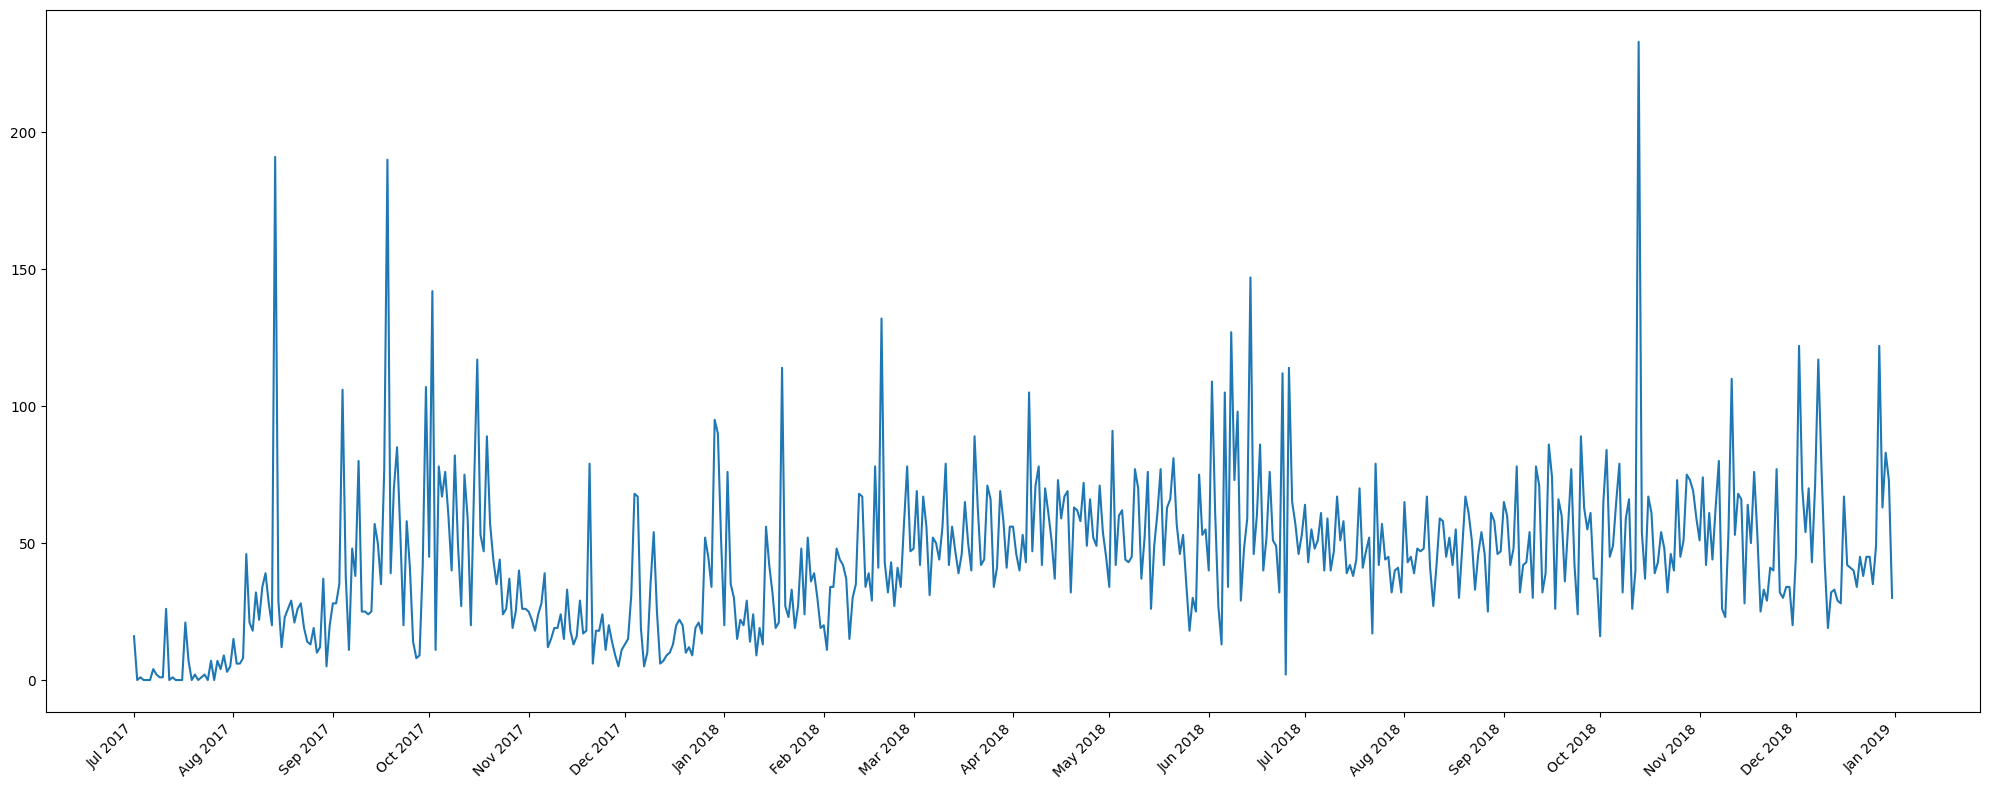

In [22]:
daily_demand_df = (
    df_clean.groupby('booking_date')['status']
    .sum().reset_index(name = 'demand'))


plt.figure(figsize = (20, 8))
plt.plot(daily_demand_df['booking_date'], daily_demand_df['demand'])

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xticks(rotation = 45, ha = 'right')

plt.tight_layout()
plt.show()

**Observation**

There are **clear seasonal trends** in the data, with **notable peaks consistently occurring between August and October** in both years. This pattern suggests **increased bookings during late summer and early autumn**.

Several **anomalies stand out**, particularly in **August and September of 2017**, and again in **November 2018**. These may correspond to **special events, holidays, or conferences** that caused unusual spikes in activity.

In addition, there are **stable but significant peaks** around **early and late December**, extending into **January**, likely due to the **holiday season travel**. Other peaks appear in **March, June, and July of 2018**, which could be asa result of some smaller **seasonal demand** or even **regional events**.

## Daily Demand by Room Type

In [23]:
daily_room_demand_df = (
    df_clean.groupby(['booking_date', 'room_type'])['status']
    .sum().reset_index(name = 'demand'))

daily_room_demand_df.room_type.value_counts()

room_type
1    549
4    473
6    352
2    240
5    151
7    115
3      6
Name: count, dtype: int64

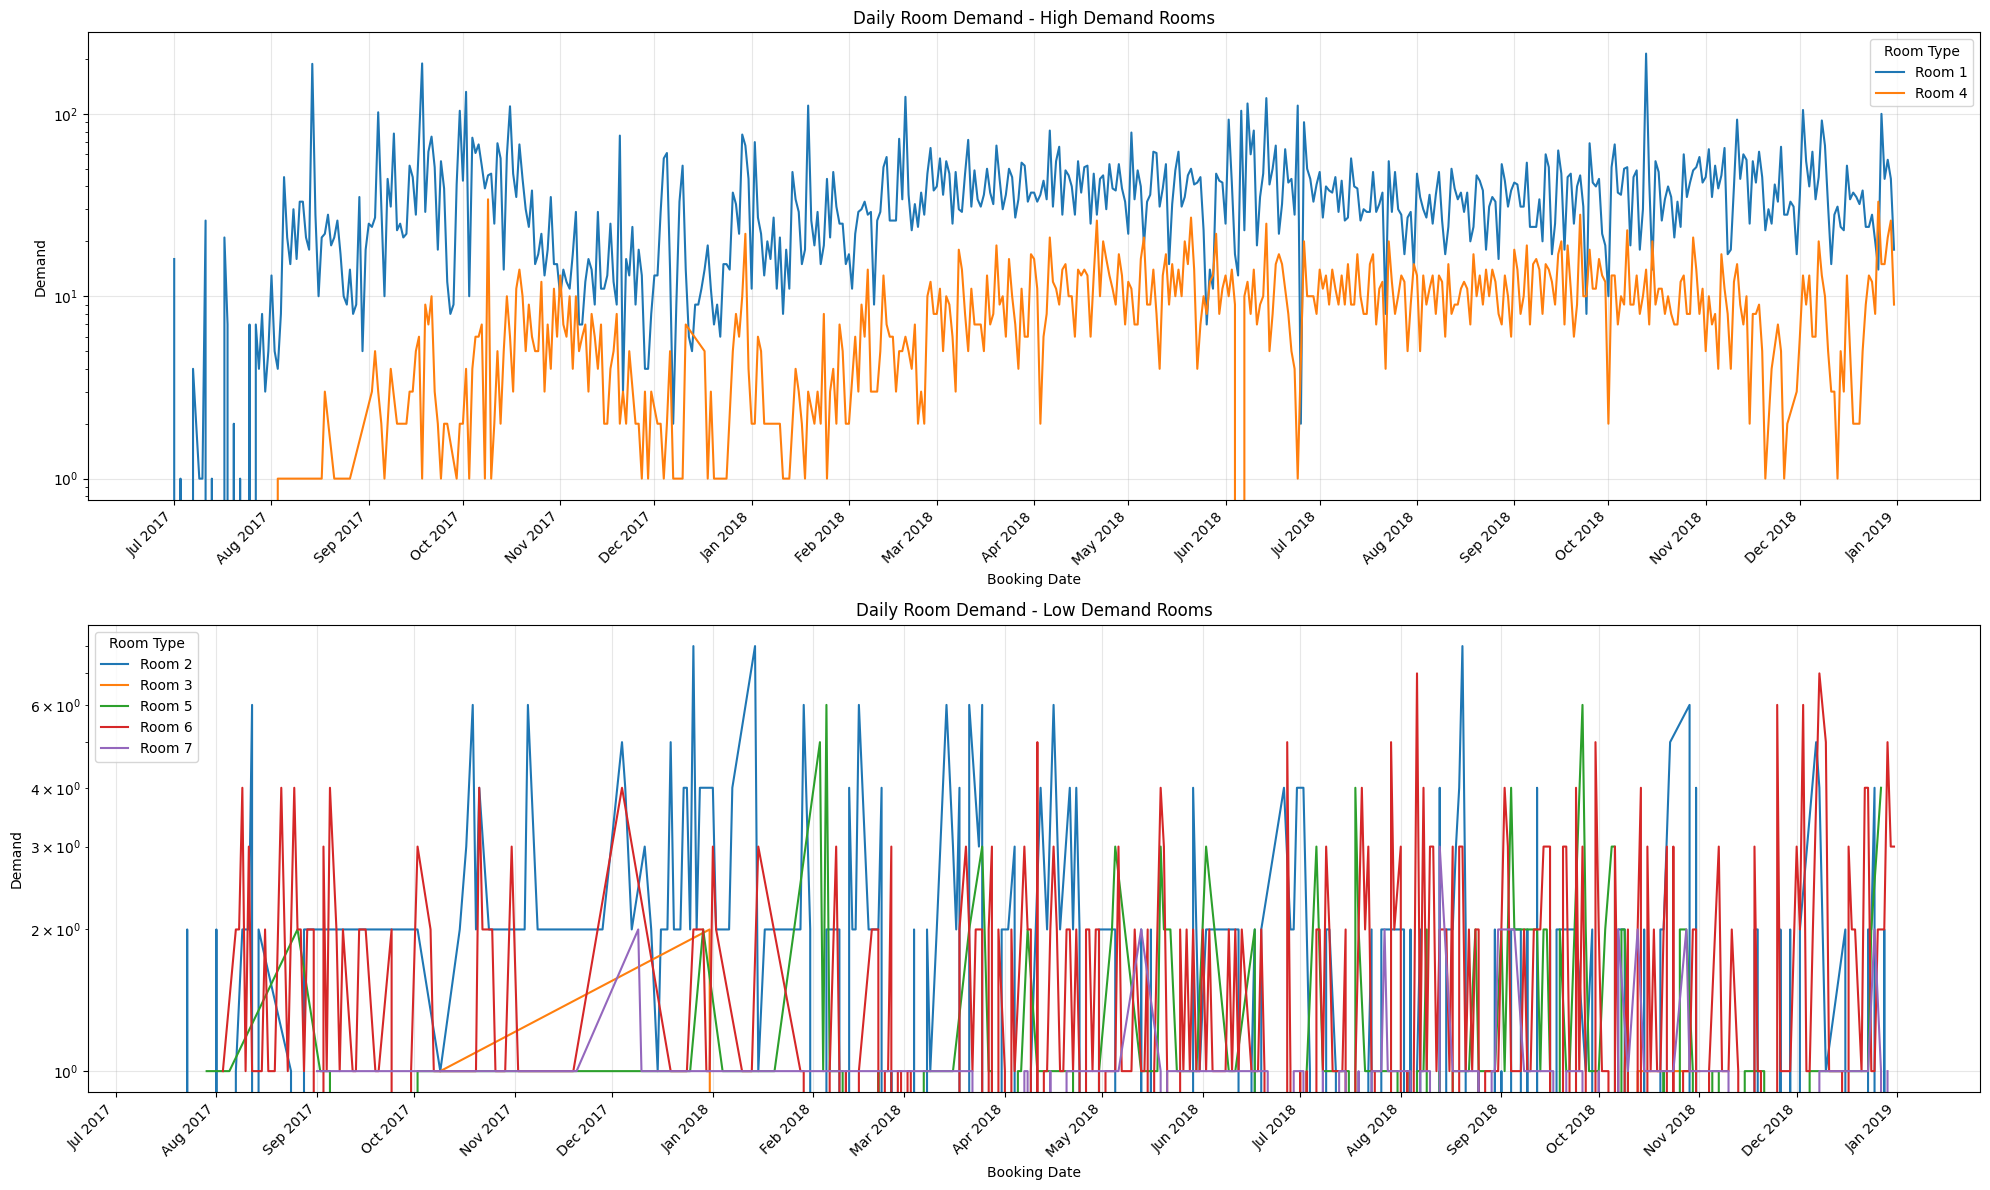

In [24]:
high_demand_rooms = [1, 4]
low_demand_rooms = [2, 3, 5, 6, 7]

plt.figure(figsize = (20, 12))

for i, (rooms, title) in enumerate([(high_demand_rooms, 'High Demand Rooms'), 
                                  (low_demand_rooms, 'Low Demand Rooms')], 1):
   plt.subplot(2, 1, i)
   
   for room_type in rooms:
       df_subset = daily_room_demand_df[daily_room_demand_df['room_type'] == room_type]
       plt.plot(df_subset['booking_date'], df_subset['demand'], label = f'Room {room_type}')
       
       plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
       plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
   
   plt.xlabel('Booking Date')
   plt.ylabel('Demand')
   plt.yscale('log')
   plt.title(f'Daily Room Demand - {title}')
   plt.legend(title = 'Room Type')
   plt.xticks(rotation = 45, ha = 'right')
   plt.grid(True, alpha = 0.3)

plt.tight_layout()
plt.show()

**Observation**   

Room types ***1 and 4*** are the most in demand and follow a relatively similar trend, they are also quite stable in comparison to the others.   

Room types ***2, 3, 5, 6, and 7*** on the other hand are a little less in demand and more sporandic in nature when compared to the demand of `1 and 4`... They may be more dominant with a specific user segment or last minute buyers, however, the goal of this project is to study the most in demand rooms, understand those customer behaviours and their acquisition channels. I will focus on that.

## Analysis of Variance (ANOVA) & Correlation

In [25]:
# just aggregating all features per daily basis.

daily_features = df_clean[df_clean['status'] == 1].groupby(['booking_date', 'room_type']).agg({
    'n_adults':'mean',   'n_children':'mean',   'weekend_nights': 'mean',
    'week_nights':'mean',   'meal_plan':lambda x: x.mode()[0],
    'car_parking_space':'mean',   'lead_time':'mean',   
    'year': 'first',   'month':'first',   'date':'first',
    'previous_cancellations':'mean',   'previous_bookings_not_canceled':'mean',
    'avg_room_price':'mean',   'special_requests':'mean',
    'market_segment_Complementary':'mean', 'market_segment_Corporate':'mean',
    'market_segment_Offline':'mean', 'market_segment_Online':'mean'}).reset_index()

full_data = pd.merge(daily_demand_df, daily_features, on = 'booking_date')

In [26]:
# collecting all significant variables as and their p-values
sigificant_covariates = []

# ANOVA
categorical_cols = ['meal_plan', 'room_type', 'car_parking_space', 'year', 'month', 'date']

print('ANOVA results:')
for col in categorical_cols:
    groups = [group['demand'].values for _, group in full_data.groupby(col)]
    if len(groups) > 1:
        f_stat, p_val = stats.f_oneway(*groups)
        print(f'{col:35} F = {f_stat:.3f}, p = {p_val:.4f}')
        if p_val <= 0.05:
            sigificant_covariates.append(col)
    else:
        print(f'{col:35}: Skipped (only one group present)')


# Pearson correlation
numeric_cols = [
    'n_adults', 'n_children', 'weekend_nights', 'week_nights',
    'lead_time', 'previous_cancellations', 'previous_bookings_not_canceled',
    'avg_room_price', 'special_requests', 'market_segment_Complementary',
    'market_segment_Corporate', 'market_segment_Offline', 'market_segment_Online']

print('\nPearson correlation results:')
for col in numeric_cols:
    corr, p_val = stats.pearsonr(full_data[col], full_data['demand'])
    print(f"{col:35} r = {corr:.3f}, p = {p_val:.4f}")
    if p_val <= 0.05:
            sigificant_covariates.append(col)

print(f'\n\nAll significant variables with p-value <= 0.05:\n{sigificant_covariates}')

ANOVA results:
meal_plan                           F = 0.085, p = 0.9680
room_type                           F = 6.373, p = 0.0000
car_parking_space                   F = 1.816, p = 0.0000
year                                F = 120.880, p = 0.0000
month                               F = 18.711, p = 0.0000
date                                F = 3.099, p = 0.0000

Pearson correlation results:
n_adults                            r = 0.037, p = 0.1285
n_children                          r = 0.022, p = 0.3711
weekend_nights                      r = -0.075, p = 0.0019
week_nights                         r = 0.010, p = 0.6869
lead_time                           r = 0.117, p = 0.0000
previous_cancellations              r = -0.064, p = 0.0080
previous_bookings_not_canceled      r = -0.022, p = 0.3655
avg_room_price                      r = 0.195, p = 0.0000
special_requests                    r = 0.043, p = 0.0726
market_segment_Complementary        r = -0.058, p = 0.0166
market_segment_Corpo

**Observation**   

Well... ***meal plan, number of visitors (adults and kids), number of week nights*** and a few other factors seem not to have relavant impact on the demand. On the flip side, something quite interesting pops up. of all the market segments, only the complementary segment seems to affect demand.   

**Next**, I will estimate the baseline elasticity of demand for the most in demand room types, study the customer segments for each room and reccomend marketing strategies to inform targeted marketing and positioning strategies.

# Price Elasticity of Demand Modelling

In [27]:
room_type_1_df = full_data[full_data['room_type'] == 1]
room_type_4_df = full_data[full_data['room_type'] == 4]

In [28]:
room_type_1_df['log_price'] = np.log(room_type_1_df['avg_room_price'])
room_type_1_df['log_price_squared'] = room_type_1_df['log_price'] ** 2
room_type_1_df['log_demand'] = np.log(room_type_1_df['demand'])

room_type_1_df = pd.get_dummies(room_type_1_df, columns = ['year', 'month'], drop_first = True)

# Log transforms
room_type_1_df['log_price'] = np.log(room_type_1_df['avg_room_price'])
room_type_1_df['log_price_squared'] = room_type_1_df['log_price'] ** 2
room_type_1_df['log_demand'] = np.log(room_type_1_df['demand'])

room_type_1_df = room_type_1_df.sort_values('log_price')

## Room Type 1 Baseline - Linear & Polynomial Estimates

In [29]:
# linear OLS
X_linear_1 = sm.add_constant(room_type_1_df['log_price'])
model_linear_1 = sm.OLS(room_type_1_df['log_demand'], X_linear_1).fit()
room_type_1_df['pred_linear'] = model_linear_1.predict(X_linear_1)

# Quadratic OLS - log-price
room_type_1_df['log_price_squared'] = room_type_1_df['log_price'] ** 2
X_poly_1 = sm.add_constant(room_type_1_df[['log_price', 'log_price_squared']])
model_poly_1 = sm.OLS(room_type_1_df['log_demand'], X_poly_1).fit()
room_type_1_df['pred_poly'] = model_poly_1.predict(X_poly_1)

In [30]:
summary1 = model_linear_1.summary().as_html()
summary2 = model_poly_1.summary().as_html()

html = f"""
<div style="display: flex;">
  <div style="margin-right: 2em">{summary1}</div>
  <div>{summary2}</div>
</div>
"""
display(HTML(html))

**Observation**   

The polynomial (quadratic) model fits the data better, and its term `-6.1798`, together with the linear term suggests that the ***relationship between price and demand is non-linear*** and of an `inverted U-shape`, meaning that demand is in-elastic however, ****after price exceeds a threshold, demand become elastic, and rooms Type 1 becomes less and less attractive to customers****. I expect somewhat similar pattern with ***room type 4*** since their daily demand line plots looked similar.   

**Note** that this is only the baseline, and many other `confounding factors i.e` the ones with p-values < 0.05 will definately provide more insights to help the model capture variance in data properly.... I wll explore that shortly.   

In [31]:
elasticities_1 = model_poly_1.params['log_price'] + 2 * model_poly_1.params['log_price_squared'] * room_type_1_df['log_price']

overall_elasticity_1 = elasticities_1.mean()

print(f'Overall average elasticity across "Room Type 1": {overall_elasticity_1:.3f}')
print(f'Distribution of estimated price elasticities_1elasticities_1:\n{elasticities_1.describe()[["min", "25%", "50%", "75%", "max"]]}')

Overall average elasticity across "Room Type 1": 1.846
Distribution of estimated price elasticities_1elasticities_1:
min   -5.572166
25%    0.238515
50%    1.689199
75%    3.535090
max    7.983978
Name: log_price, dtype: float64


## Room Type 1 - Controls + Polynomial Estimates

In [32]:
X_full = room_type_1_df[[
    'log_price', 'log_price_squared',
    'weekend_nights', 'lead_time', 'previous_cancellations',
    'market_segment_Complementary'
] + [col for col in room_type_1_df.columns if col.startswith(('year_', 'month_'))]]

bool_cols = X_full.select_dtypes(include = 'bool').columns
X_full[bool_cols] = X_full[bool_cols].astype(int)

X_full = sm.add_constant(X_full)
model_poly_cov = sm.OLS(room_type_1_df['log_demand'], X_full).fit()
room_type_1_df['pred_poly_cov'] = model_poly_cov.predict(X_full)

In [33]:
# pointwise elasticities from the model with controls
rt_1_elasticities_cov = (model_poly_cov.params['log_price'] + 2 * model_poly_cov.params['log_price_squared'] * room_type_1_df['log_price'])

rt_1_overall_elasticity_cov = rt_1_elasticities_cov.mean()

print(f'Overall average elasticity across "Room Type 1" (with controls): {rt_1_overall_elasticity_cov:.3f}')
print(f'Distribution of estimated elasticities:\n{rt_1_elasticities_cov.describe()[["min", "25%", "50%", "75%", "max"]]}')

Overall average elasticity across "Room Type 1" (with controls): 1.743
Distribution of estimated elasticities:
min   -4.435810
25%    0.404458
50%    1.612871
75%    3.150489
max    6.856391
Name: log_price, dtype: float64


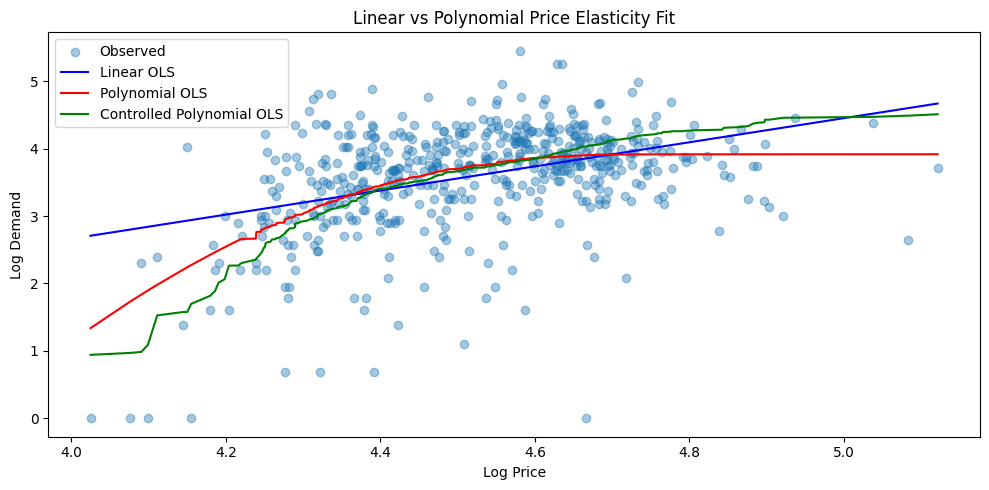

In [34]:
plt.figure(figsize = (10, 5))

plt.scatter(room_type_1_df['log_price'], room_type_1_df['log_demand'], alpha = 0.4, label = 'Observed')

plt.plot(room_type_1_df['log_price'], sorted(room_type_1_df['pred_linear']),
         label = 'Linear OLS', color = 'blue')
plt.plot(room_type_1_df['log_price'], sorted(room_type_1_df['pred_poly']),
         label = 'Polynomial OLS', color = 'red')
plt.plot(room_type_1_df['log_price'], sorted(room_type_1_df['pred_poly_cov']),
         label = 'Controlled Polynomial OLS', color = 'green')

plt.xlabel('Log Price')
plt.ylabel('Log Demand')
plt.title('Linear vs Polynomial Price Elasticity Fit')
plt.legend()
plt.tight_layout();

**Observation**   

The comparison above show that the linear fit assumes a constant trend, while the polynomial fit (red) captures curvature in the data. The controlled polynomial (green) also follows a parabolic shape, ***but since it is adjusted for other confounding factors such as lead time and the rest***, it results in a more refined fit.

In [35]:
rmt_1_beta_1 = model_poly_1.params['log_price']
rmt_1_beta_2 = model_poly_1.params['log_price_squared']

rmt_1_beta_1_cov = model_poly_cov.params['log_price']
rmt_1_beta_2_cov = model_poly_cov.params['log_price_squared']

# log_price where elasticity = -1:  b1 + 2*b2*log_price = -1
rt1_log_price_unit_elastic_baseline = (-1 - rmt_1_beta_1) / (2 * rmt_1_beta_2)
rt1_log_price_unit_elastic_cov = (-1 - rmt_1_beta_1_cov) / (2 * rmt_1_beta_2_cov)

rt1_price_unit_elastic_baseline = np.exp(rt1_log_price_unit_elastic_baseline)
rt1_price_unit_elastic_cov = np.exp(rt1_log_price_unit_elastic_cov)

print(f'Unit-elasticity log-price (Baseline): {rt1_log_price_unit_elastic_baseline:.3f} -> Price: {rt1_price_unit_elastic_baseline:.2f}')
print(f'Unit-elasticity log-price (With Controls): {rt1_log_price_unit_elastic_cov:.3f} -> Price: {rt1_price_unit_elastic_cov:.2f}')

Unit-elasticity log-price (Baseline): 4.752 -> Price: 115.76
Unit-elasticity log-price (With Controls): 4.788 -> Price: 120.03


In [36]:
rmt_1_turning_point_log_price_1_cont = -rmt_1_beta_1_cov / (2 * rmt_1_beta_2_cov)
rmt_1_turning_point_price_1_cont = np.exp(rmt_1_turning_point_log_price_1_cont)

print(f'According to the controlled polynomial model, demand becomes elastic after prices exceed *{round(rmt_1_turning_point_price_1_cont, 2)}*')

According to the controlled polynomial model, demand becomes elastic after prices exceed *108.92*


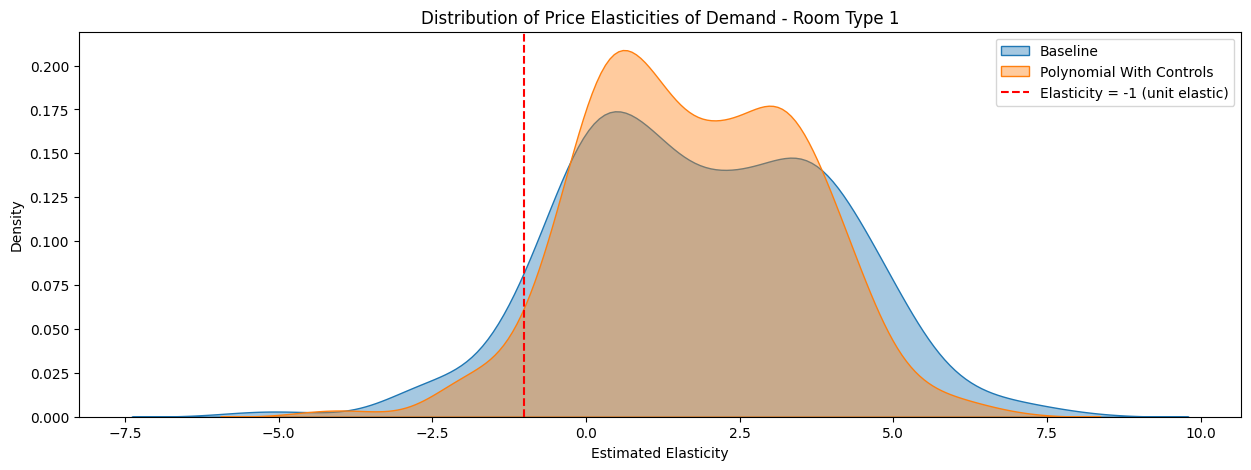

In [37]:
plt.figure(figsize = (15, 5))
sns.kdeplot(elasticities_1, fill = True, label = 'Baseline', alpha = 0.4)
sns.kdeplot(rt_1_elasticities_cov, fill = True, label = 'Polynomial With Controls', alpha = 0.4)

plt.axvline(-1, linestyle = '--', color = 'red', label = 'Elasticity = -1 (unit elastic)')

plt.title('Distribution of Price Elasticities of Demand - Room Type 1')
plt.xlabel('Estimated Elasticity')
plt.ylabel('Density')
plt.legend();

**Observation**   

**Demand is mostly inelastic** i.e **above -1**, indicating that price increases may **still increase total revenue** without significantly reducing demand. The distribution is also **Bimodal** in nature, especially in the **polynomial model with controls**, suggesting the presence of **two distinct demand behaviors**. I'd like to attribute that to seasonal trends, or market ***segments*** actually.   

Just as the scatter plot showed, the **wide Spread of elasticity values**, from highly negative to strongly positive, hint at a **variation** in how price affects demand across bookings. **Next**, Since demand is multimodal, I will investigate the cause, and acquisition channels further.

## Room Type 1 - Further Investigation on Multimodality

### Peak Group Location-Based Cluster Studies

In [38]:
elasticities = room_type_1_df['pred_poly_cov']
kde = gaussian_kde(elasticities)
x_vals = np.linspace(elasticities.min(), elasticities.max(), 1000)
y_vals = kde(x_vals)

peaks, _ = find_peaks(y_vals)
peak_locations = x_vals[peaks]

print(f'Number of peaks found: {len(peaks)}')
print(f'Peak locations: {peak_locations}')

Number of peaks found: 3
Peak locations: [0.99544046 1.8273696  3.86613158]


In [39]:
def assign_to_nearest_peak(val, peak_locations):
    return np.argmin(np.abs(val - peak_locations))

room_type_1_df['peak_group'] = room_type_1_df['pred_poly_cov'].apply(
    lambda x: assign_to_nearest_peak(x, peak_locations))

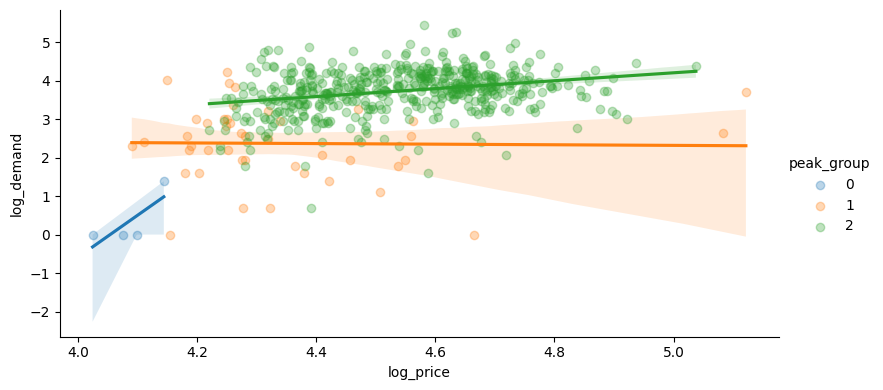

In [40]:
sns.lmplot(data = room_type_1_df, x = 'log_price', y = 'log_demand',
    hue = 'peak_group', scatter_kws = {'alpha': 0.3}, height = 4, aspect = 2);

**Proportional Variables (%):


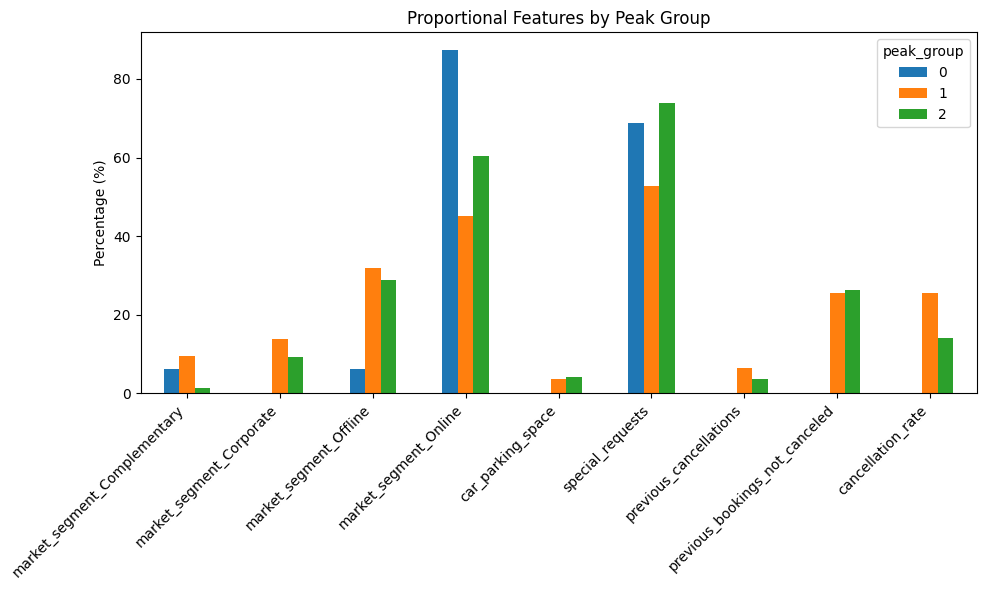


**Continuous Feature Summary by Peak Group:


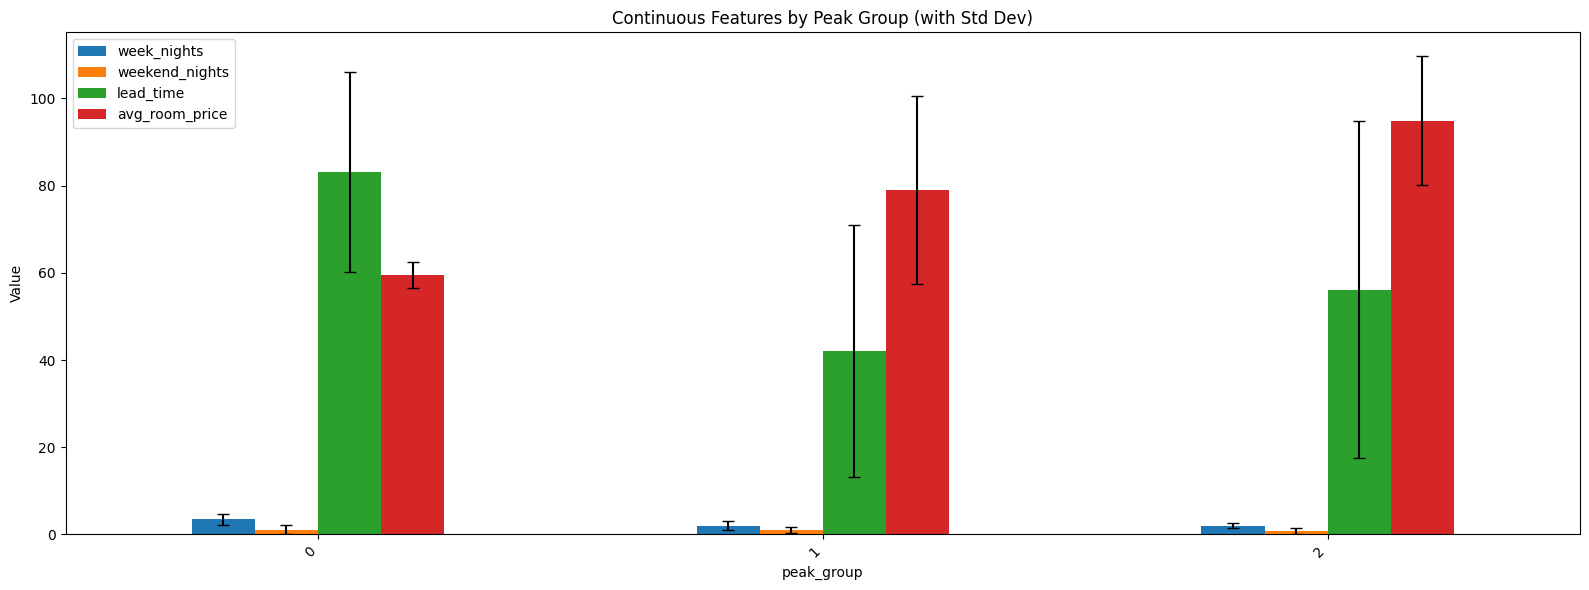

In [41]:
proportional_vars = [
    'market_segment_Complementary', 'market_segment_Corporate',
    'market_segment_Offline', 'market_segment_Online',
    'car_parking_space', 'special_requests',
    'previous_cancellations', 'previous_bookings_not_canceled']

continuous_vars = ['week_nights', 'weekend_nights', 'lead_time', 'avg_room_price']

prop_summary = room_type_1_df.groupby('peak_group')[proportional_vars].mean() * 100
prop_summary['cancellation_rate'] = (
    room_type_1_df.groupby('peak_group')['previous_cancellations'].mean() /
    room_type_1_df.groupby('peak_group')['previous_bookings_not_canceled'].mean()) * 100

print('**Proportional Variables (%):')
prop_summary.T.plot(kind = 'bar', figsize = (10, 6), title = 'Proportional Features by Peak Group')
plt.ylabel('Percentage (%)')
plt.xticks(rotation = 45, ha = 'right')
plt.tight_layout()
plt.show()


cont_summary = room_type_1_df.groupby('peak_group')[continuous_vars].agg(['mean', 'std', 'min', 'max']).round(2)
print('\n**Continuous Feature Summary by Peak Group:')

means = cont_summary.xs('mean', level = 1, axis = 1)
stds = cont_summary.xs('std', level = 1, axis = 1)

ax = means.plot(kind = 'bar', yerr = stds, capsize = 4, figsize = (16, 6))
plt.title('Continuous Features by Peak Group (with Std Dev)')
plt.ylabel('Value')
plt.xticks(rotation = 45, ha = 'right')
plt.tight_layout()
plt.show()

In [42]:
prop_summary_peak_gp = prop_summary.T.to_html()
means_peak_gp = means.to_html()

html = f"""
<div style="display: flex;">
  <div style="margin-right: 2em">{prop_summary_peak_gp}</div>
  <div>{means_peak_gp}</div>
</div>
"""

display(HTML(html))

**Observation**    

Since **`market_segment_online, special requests, and lead_time`** vary very differently across the the dfferent peak groups, I will create interaction terms and see what their coefficients say, to further differenciate the customer groups.

In [43]:
interaction_vars = [
    'log_price', 'log_price_squared',
    'weekend_nights', 'lead_time', 'previous_cancellations',
    'market_segment_Complementary', 'market_segment_Online',
    'special_requests', 'log_price_x_lead_time',
    'log_price_x_weekend', 'log_price_x_special_requests', 'log_price_x_online', 'date'
] + [col for col in room_type_1_df.columns if col.startswith(('year_', 'month_'))]

# interaction terms
room_type_1_df['log_price_x_weekend'] = room_type_1_df['log_price'] * room_type_1_df['weekend_nights']
room_type_1_df['log_price_x_special_requests'] = room_type_1_df['log_price'] * room_type_1_df['special_requests']
room_type_1_df['log_price_x_online'] = room_type_1_df['log_price'] * room_type_1_df['market_segment_Online']
room_type_1_df['log_price_x_lead_time'] = room_type_1_df['log_price'] * room_type_1_df['lead_time']

X_int = room_type_1_df[interaction_vars].copy()
X_int[bool_cols] = X_int[bool_cols].astype(int)
X_int = sm.add_constant(X_int)

interaction_model = sm.OLS(room_type_1_df['log_demand'], X_int).fit()
display(interaction_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_demand   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     25.18
Date:                Mon, 09 Jun 2025   Prob (F-statistic):           4.84e-73
Time:                        09:39:29   Log-Likelihood:                -407.17
No. Observations:                 536   AIC:                             866.3
Df Residuals:                     510   BIC:                             977.7
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                         -102.8109     13.319     -7.719      0.000    -128.977     -76.644
log_price                       45.5178      5.843      7.790      0.000      34.038      56.998
log_price_squared               -4.8452      0.643     -7.536      0.000      -6.108      -3.582
weekend_nights                  -0.4419      0.926     -0.477      0.633      -2.261       1.377
lead_time                        0.0069      0.022      0.320      0.749      -0.036       0.050
previous_cancellations          -0.0245      0.204     -0.120      0.904      -0.426       0.377
market_segment_Complementary    -2.0085      0.377     -5.330      0.000      -2.749      -1.268
market_segment_Online           -9.2533      3.511     -2.636      0.009     -16.150      -2.356
special_requests                 6.3240      2.598      2.434      0.015       1.220      11.428
log_price_x_lead_time           -0.0012      0.005     -0.244      0.808      -0.011       0.008
log_price_x_weekend              0.0735      0.205      0.359      0.720      -0.329       0.476
log_price_x_special_requests    -1.4259      0.577     -2.470      0.014      -2.560      -0.292
log_price_x_online               1.9585      0.783      2.500      0.013       0.420       3.497
date                            -0.0046      0.003     -1.742      0.082      -0.010       0.001
year_2018                        0.5046      0.076      6.656      0.000       0.356       0.654
month_2                          0.1112      0.148      0.751      0.453      -0.180       0.402
month_3                          0.2179      0.149      1.461      0.145      -0.075       0.511
month_4                          0.0073      0.162      0.045      0.964      -0.310       0.325
month_5                         -0.2871      0.167     -1.722      0.086      -0.615       0.040
month_6                         -0.2731      0.170     -1.603      0.109      -0.608       0.062
month_7                         -0.7194      0.161     -4.470      0.000      -1.036      -0.403
month_8                         -0.2718      0.167     -1.626      0.104      -0.600       0.057
month_9                         -0.0466      0.172     -0.270      0.787      -0.385       0.292
month_10                         0.0445      0.165      0.271      0.787      -0.279       0.368
month_11                        -0.0338      0.148     -0.229      0.819      -0.324       0.256
month_12                         0.1713      0.144      1.188      0.236      -0.112       0.455
==============================================================================
Omnibus:                      134.189   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              633.007
Skew:                          -1

**Observation**    

Interesting... Of all the interaction terms introduced, two relationship reveal something quite interesting:
- **`log price` & `special requests`**
- **`log price` & `online market segment`**

***Guests who make more special requests, are more price sensitive***... I shall further observe the group with the most amount of special requests in order to fully separate them from the rest.

### KMeans Cluster Studies

In [44]:
clustering_vars = [
    'demand', 'lead_time', 'week_nights', 'weekend_nights',
    'log_price_squared', 'log_price', 'previous_cancellations', 'market_segment_Complementary']

scaler = StandardScaler()
X = room_type_1_df[clustering_vars].copy()
X_scaled = X.copy()
X_scaled[clustering_vars] = scaler.fit_transform(X[clustering_vars])

kmeans = KMeans(n_clusters = 3, random_state = 42)
room_type_1_df['kmeans_cluster'] = kmeans.fit_predict(X_scaled)

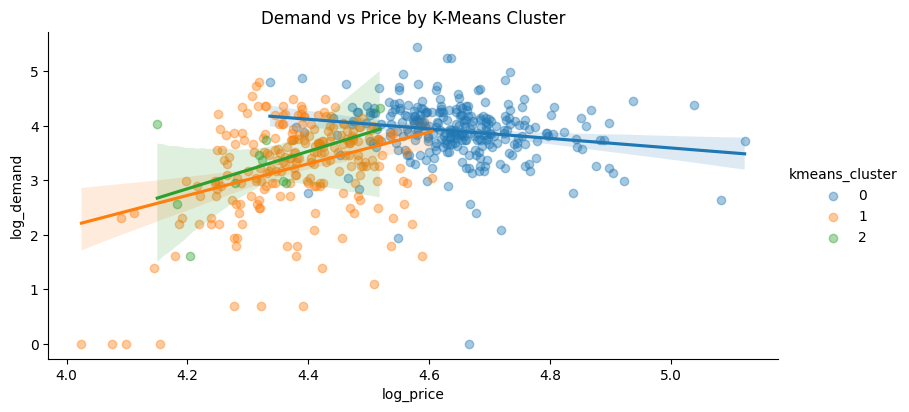

In [45]:
sns.lmplot(
    data = room_type_1_df, x = 'log_price', y = 'log_demand',
    hue = 'kmeans_cluster', scatter_kws = {'alpha': 0.4}, height = 4, aspect = 2)

plt.title('Demand vs Price by K-Means Cluster');

**Proportional Variables (%):


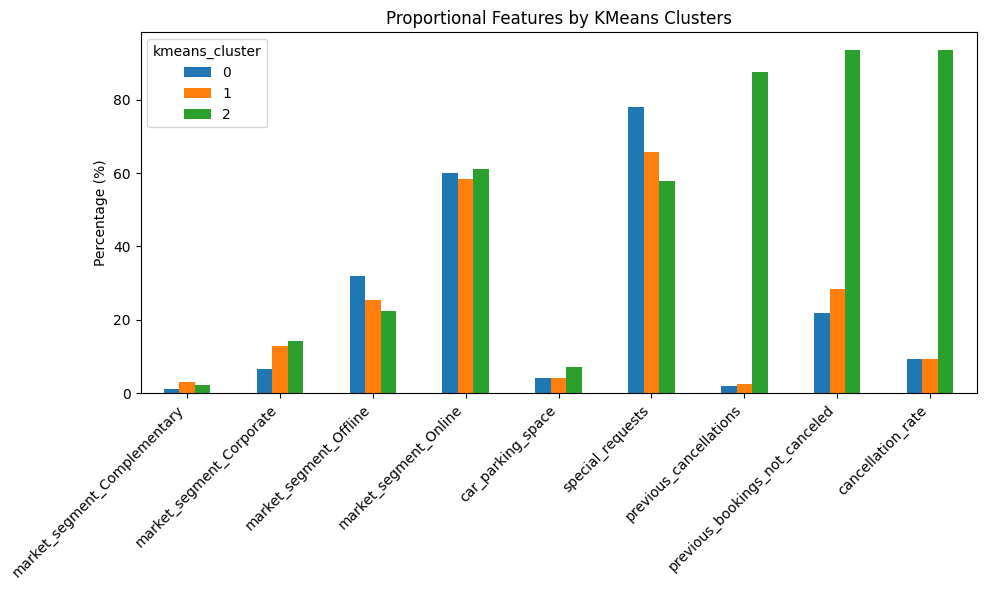


**Continuous Feature Summary by KMeans Cluster:


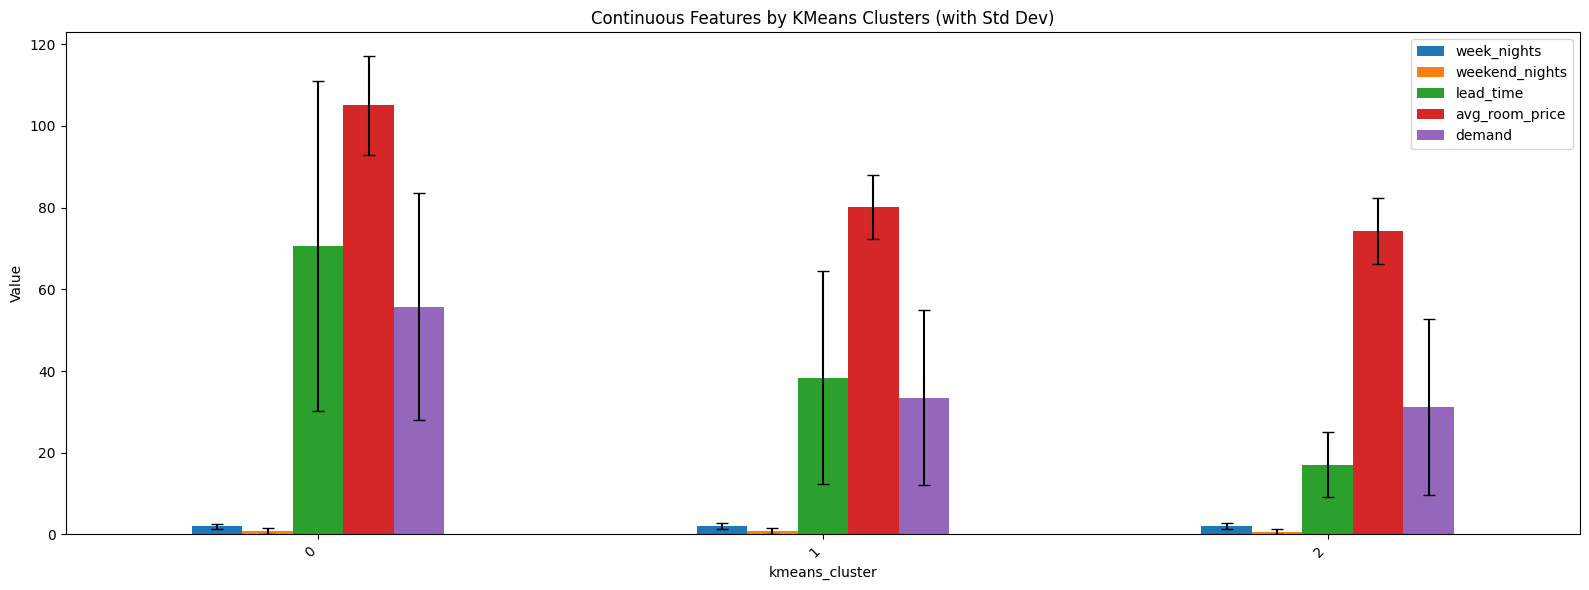

In [46]:
prop_summary = room_type_1_df.groupby('kmeans_cluster')[proportional_vars].mean() * 100

prop_summary['cancellation_rate'] = (
    room_type_1_df.groupby('kmeans_cluster')['previous_cancellations'].mean() /
    room_type_1_df.groupby('kmeans_cluster')['previous_bookings_not_canceled'].mean()) * 100

print("**Proportional Variables (%):")
prop_summary.T.plot(kind = 'bar', figsize = (10, 6), title = 'Proportional Features by KMeans Clusters')
plt.ylabel('Percentage (%)')
plt.xticks(rotation = 45, ha = 'right')
plt.tight_layout()
plt.show()

cont_summary = room_type_1_df.groupby('kmeans_cluster')[continuous_vars + ['demand']].agg(['mean', 'std', 'min', 'max']).round(2)
print("\n**Continuous Feature Summary by KMeans Cluster:")

means = cont_summary.xs('mean', level = 1, axis = 1)
stds = cont_summary.xs('std', level = 1, axis = 1)

ax = means.plot(kind = 'bar', yerr = stds, capsize = 4, figsize = (16, 6))
plt.title('Continuous Features by KMeans Clusters (with Std Dev)')
plt.ylabel('Value')
plt.xticks(rotation = 45, ha = 'right')
plt.tight_layout()
plt.show()

In [47]:
prop_summary_kmeans_gp = prop_summary.T.to_html()
means_kmeans_gp = means.to_html()

html = f"""
<div style="display: flex;">
  <div style="margin-right: 2em">{prop_summary_kmeans_gp}</div>
  <div>{means_kmeans_gp}</div>
</div>
"""

display(HTML(html))

## **Final Observation - Room Type 1**

The **KMeans clustering approach** reveals far more **realistic and actionable customer insights** compared to the segments generated from the **feature-engineered predictions of the controlled polynomial model**.

- **`Cluster 0` - Likely Leisure Travellers**
    - These customers appear to be **slightly price sensitive** and tend to **compare options** carefully before booking. They are **value seekers** who go for the **best deals**.
    - They are **organised planners**, as they account for the **highest frequency of custom requests**, and **longest lead times**.
    - They also to tend **stay the longest** at the hotel on average. eventhough they are **not the most frequent guests**, they are **commitment** to their bookings, with **low cancellation rates** reflect their decision-making certainty.
    - They book through both offline and online channels, though like most other guests, the **online channel is slightly more favored**.
      
.

- **`Cluster 1` - More Flexible Customers**
    - These guests are **more flexible** in their planning, they do **not plan far in advance**, compared to Cluster 0.
    - They tend to **stay longer** than leisure travelers, especially during **week nights**, and their **spending is average**, neither high or low... However, they are less price sensitive, and are ***able to pay extra*** for perceived fairness.

.

- **`Cluster 2` - Premium Customers (Likely Business Travellers)**
    - These customers **highly value flexibility**, they have the **highest cancellation rates**, **shortest booking lead times**, and **shorter stays**, mostly on **weekdays**.
    - This behavior suggests **business travel**, likely for events or meetings in the hotel’s surrounding area. They are **price inelastic**, willing to **spend significantly** for convenience or necessity, and their primary driver seems to be **location, flexibility and timing**, rather than price or leisure.


## **Cluster Recommendations**

- **Cluster 0 - Leisure Travellers**
    - Offer **targeted promotions** such as early bird discounts, **tourist attraction arrangements** or bundle deals.
    - Encourage **direct bookings** through loyalty incentives and price guarantees... This should hopefully bring them back, should they decide to visit the city again.
    - Highlight **customisable options** (room upgrades, flexible check-in) to appeal to their planning behavior.
    
.

- **Cluster 1 - Flexible Guests**
    - Promote **mid-range packages** and **extended-stay discounts**.
    - Experiment with **last-minute deals** to encourage shorter planning cycles.
    - Market **weekday offers** to align with their preference for weeknight stays.

.

- **Cluster 2 - Premium/Business Travellers**
    - Provide **corporate or executive packages** that offer high flexibility.
    - Emphasise **proximity to business or event venues**, fast check-in/out, and premium amenities.
    - No generic discounts whatsoever, focus on **value-added services** like airport pickup, express laundry...

## Room Type 4 - Linear & Polynomial Estimates

In [48]:
# room_type_4_df['log_price'] = np.log(room_type_4_df['avg_room_price'])
# room_type_4_df['log_price_squared'] = room_type_4_df['log_price'] ** 2
# room_type_4_df['log_demand'] = np.log(room_type_4_df['demand'])

# room_type_4_df = pd.get_dummies(room_type_4_df, columns = ['year', 'month'], drop_first = True)

# # Log transforms
# room_type_4_df['log_price'] = np.log(room_type_4_df['avg_room_price'])
# room_type_4_df['log_price_squared'] = room_type_4_df['log_price'] ** 2
# room_type_4_df['log_demand'] = np.log(room_type_4_df['demand'])

# room_type_4_df = room_type_4_df.sort_values('log_price')

In [49]:
# # linear OLS
# X_linear_4 = sm.add_constant(room_type_4_df['log_price'])
# model_linear_4 = sm.OLS(room_type_4_df['log_demand'], X_linear_4).fit()
# room_type_4_df['pred_linear'] = model_linear_4.predict(X_linear_4)

# # Quadratic OLS - log-price
# room_type_4_df['log_price_squared'] = room_type_4_df['log_price'] ** 2
# X_poly_4 = sm.add_constant(room_type_4_df[['log_price', 'log_price_squared']])
# model_poly_4 = sm.OLS(room_type_4_df['log_demand'], X_poly_4).fit()
# room_type_4_df['pred_poly'] = model_poly_4.predict(X_poly_4)

In [50]:
# summary1 = model_linear_4.summary().as_html()
# summary2 = model_poly_4.summary().as_html()

# html = f"""
# <div style="display: flex;">
#   <div style="margin-right: 2em">{summary1}</div>
#   <div>{summary2}</div>
# </div>
# """
# display(HTML(html))

**Observation**   

As expected, the polynomial model explains more variance, its quadratic corfficient together with that of the linear terms explain show a slightly similar interved U-shape pattern.

## Room Type 4 - Controls + Quadratic Estimates

In [51]:
# X_full = room_type_4_df[[
#     'log_price', 'log_price_squared',
#     'weekend_nights', 'lead_time', 'previous_cancellations',
#     'market_segment_Complementary'
# ] + [col for col in room_type_4_df.columns if col.startswith(('year_', 'month_'))]]

# bool_cols = X_full.select_dtypes(include = 'bool').columns
# X_full[bool_cols] = X_full[bool_cols].astype(int)

# X_full = sm.add_constant(X_full)
# model_poly_cov = sm.OLS(room_type_4_df['log_demand'], X_full).fit()
# room_type_4_df['pred_poly_cov'] = model_poly_cov.predict(X_full)

In [52]:
model_poly_cov.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_demand   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     31.43
Date:                Mon, 09 Jun 2025   Prob (F-statistic):           3.29e-71
Time:                        09:39:33   Log-Likelihood:                -424.48
No. Observations:                 536   AIC:                             887.0
Df Residuals:                     517   BIC:                             968.4
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                         -109.5388     12.884     -8.502      0.000    -134.851     -84.227
log_price                       48.2917      5.670      8.517      0.000      37.153      59.431
log_price_squared               -5.1477      0.622     -8.272      0.000      -6.370      -3.925
weekend_nights                  -0.1531      0.037     -4.167      0.000      -0.225      -0.081
lead_time                        0.0031      0.001      4.116      0.000       0.002       0.005
previous_cancellations          -0.0066      0.205     -0.032      0.974      -0.410       0.396
market_segment_Complementary    -1.6926      0.374     -4.530      0.000      -2.427      -0.959
year_2018                        0.4094      0.074      5.535      0.000       0.264       0.555
month_2                          0.1429      0.151      0.949      0.343      -0.153       0.439
month_3                          0.2398      0.151      1.592      0.112      -0.056       0.536
month_4                         -0.0032      0.161     -0.020      0.984      -0.320       0.314
month_5                         -0.2186      0.167     -1.308      0.192      -0.547       0.110
month_6                         -0.2420      0.171     -1.419      0.157      -0.577       0.093
month_7                         -0.8129      0.160     -5.067      0.000      -1.128      -0.498
month_8                         -0.3823      0.164     -2.335      0.020      -0.704      -0.061
month_9                         -0.0738      0.169     -0.435      0.663      -0.407       0.259
month_10                         0.0158      0.161      0.098      0.922      -0.301       0.332
month_11                        -0.0502      0.141     -0.356      0.722      -0.327       0.227
month_12                         0.1525      0.140      1.087      0.277      -0.123       0.428
==============================================================================
Omnibus:                       57.741   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              186.891
Skew:                          -0.471   Prob(JB):                     2.61e-41
Kurtosis:                       5.735   Cond. No.                     4.16e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.16e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [53]:
# # pointwise elasticities from the model with controls
# rt_4_elasticities_cov = (model_poly_cov.params['log_price'] + 2 * model_poly_cov.params['log_price_squared'] * room_type_4_df['log_price'])

# rt_4_overall_elasticity_cov = rt_4_elasticities_cov.mean()

# print(f'Overall average elasticity across "Room Type 4" (with controls): {rt_4_overall_elasticity_cov:.3f}')
# print(f'Distribution of estimated elasticities:\n{rt_4_elasticities_cov.describe()[["min", "25%", "50%", "75%", "max"]]}')

In [54]:
# plt.figure(figsize = (10, 5))

# plt.scatter(room_type_4_df['log_price'], room_type_4_df['log_demand'], alpha = 0.4, label = 'Observed')

# plt.plot(room_type_4_df['log_price'], sorted(room_type_4_df['pred_linear']),
#          label = 'Linear OLS', color = 'blue')
# plt.plot(room_type_4_df['log_price'], sorted(room_type_4_df['pred_poly']),
#          label = 'Polynomial OLS', color = 'red')
# plt.plot(room_type_4_df['log_price'], sorted(room_type_4_df['pred_poly_cov']),
#          label = 'Controlled Polynomial OLS', color = 'green')

# plt.xlabel('Log Price')
# plt.ylabel('Log Demand')
# plt.title('Linear vs Polynomial Price Elasticity Fit')
# plt.legend()
# plt.tight_layout();

**Observation**   

As the polynomial model terms suggested, slightly inverted U-shape, not as strong as that of room type 1.

In [55]:
# rmt_4_beta_1 = model_poly_4.params['log_price']
# rmt_4_beta_2 = model_poly_4.params['log_price_squared']

# rmt_4_beta_1_cov = model_poly_cov.params['log_price']
# rmt_4_beta_2_cov = model_poly_cov.params['log_price_squared']

# # log_price where elasticity = -1:  b1 + 2*b2*log_price = -1
# rt4_log_price_unit_elastic_baseline = (-1 - rmt_4_beta_1) / (2 * rmt_4_beta_2)
# rt4_log_price_unit_elastic_cov = (-1 - rmt_4_beta_1_cov) / (2 * rmt_4_beta_2_cov)

# rt4_price_unit_elastic_baseline = np.exp(rt4_log_price_unit_elastic_baseline)
# rt4_price_unit_elastic_cov = np.exp(rt4_log_price_unit_elastic_cov)

# print(f'Unit-elasticity log-price (Baseline): {rt4_log_price_unit_elastic_baseline:.3f} -> Price: {rt4_price_unit_elastic_baseline:.2f}')
# print(f'Unit-elasticity log-price (With Controls): {rt4_log_price_unit_elastic_cov:.3f} -> Price: {rt4_price_unit_elastic_cov:.2f}')

In [56]:
# rmt_4_turning_point_log_price_1_cont = -rmt_4_beta_1_cov / (2 * rmt_4_beta_2_cov)
# rmt_4_turning_point_price_1_cont = np.exp(rmt_4_turning_point_log_price_1_cont)

# print(f'According to the controlled polynomial model, demand becomes elastic after prices exceed *{round(rmt_4_turning_point_price_1_cont, 2)}* for room type 4.')

In [57]:
# rt_4_elasticities_baseline = (model_poly_4.params['log_price'] + 2 * model_poly_4.params['log_price_squared'] * room_type_4_df['log_price'])

# plt.figure(figsize = (15, 5))
# sns.kdeplot(rt_4_elasticities_baseline, fill = True, label = 'Baseline', alpha = 0.4)
# sns.kdeplot(rt_4_elasticities_cov, fill = True, label = 'Polynomial With Controls', alpha = 0.4)

# plt.axvline(-1, linestyle = '--', color = 'red', label = 'Elasticity = -1 (unit elastic)')

# plt.title('Distribution of Price Elasticities of Demand - Room Type 4')
# plt.xlabel('Estimated Elasticity')
# plt.ylabel('Density')
# plt.legend();

**Observation**   

Quite similar to room type 1, **in the sense that demand is largely inealstic** however, this distribution is **unimodal** Also, the inclusion of controls (like `lead_time`, `market_segment`, and time dummies) shifts the elasticity distribution left by quite a margin, showing that price alone is not the only factor influencing demand of this room type.

In [58]:
# elasticities = room_type_4_df['pred_poly_cov']
# kde = gaussian_kde(elasticities)
# x_vals = np.linspace(elasticities.min(), elasticities.max(), 1000)
# y_vals = kde(x_vals)

# peaks, _ = find_peaks(y_vals)
# peak_locations = x_vals[peaks]

# print(f'Number of peaks found: {len(peaks)}')
# print(f'Peak locations: {peak_locations}')